<a href="https://colab.research.google.com/github/OmkarKotwalProject/Dominos_Work/blob/main/Dominos_Work_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Useful Libraries and Loading the dataset

In [180]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import nltk
import re
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
import sklearn.metrics as sm
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

!pip install pyspellchecker
!pip install Counter

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [181]:
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth",None)

Mounting the drive for accessing the dataset

In [182]:
from google.colab import drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [183]:
cd /content/drive/MyDrive/CUSTOMER_REVIEWS/ScrapedReviews/PROJECT SCRAPED REVIEWS/Dominos Pizza 3k/

/content/drive/MyDrive/CUSTOMER_REVIEWS/ScrapedReviews/PROJECT SCRAPED REVIEWS/Dominos Pizza 3k


In [184]:
df = pd.read_excel('All_Reviews_DP.xlsx')

In [185]:
#Keeping the original as it is.
df_review=df 

THIS IS A BACKUP LOAD OF ORIGINAL DATAFRAME, ONLY USE IF something goes wrong and need to load the dataset again.

In [186]:
# #FOR EMPTYING THE DATAFRAME
# df_review.drop(columns=['Review','Sentiment'],inplace=True)

In [187]:
# #FOR RELOADING WITH ORIGINAL RAW DATA
# df = pd.read_excel('All_Reviews_DP.xlsx')
# df_review=df

BACKUP CODE END

In [188]:
df_review['Sentiment']=df_review['Sentiment'].astype(int)

In [189]:
print(df_review.head())
print(df_review.shape)

                                                                                                                                                                                                                                                              Review  \
0                                                                                                                                                                                                                                                       its too good   
1                                                                                                                                                                                                                                                     waste of money   
2                                                                                                                                                                                                               

HOW MANY POSITIVE REVIEWS, HOW MANY NEGATIVE REVIEWS

In [190]:
print(df_review[df_review['Sentiment']==1].count())
print(df_review[df_review['Sentiment']==0].count())

Review       1543
Sentiment    1543
dtype: int64
Review       1203
Sentiment    1203
dtype: int64


In [191]:
#Checking if any null values
df_review[df_review.isna().any(axis=1)]

,Review,Sentiment


# PRE-PROCESSING!

1. Removing digits [\d]

In [192]:
df['Review']=df['Review'].replace('\d+','',regex=True)

2. Replacing special characters by empty space ‘ ‘ and dealing with any character that occurs more than twice: yummmmy => yummy

In [193]:
df_review['Review']=df_review['Review'].replace('\n', ' ',regex=True)
df_review['Review']=df_review['Review'].replace(('[^!|^.|^,|^;|^-|^@|^\w\s]'),"", regex = True)
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  sentence=sentence.replace('.', ' ')
  sentence=sentence.replace(',', ' ')
  sentence=sentence.replace('!', ' ')
  sentence=sentence.replace('.', ' ')
  sentence=sentence.replace(';', ' ')
  sentence=sentence.replace('-', ' ')
  sentence=sentence.replace('@', ' ')
  sentence=sentence.replace(')', ' ')
  sentence=sentence.replace('(', ' ')
  sentence=sentence.replace('{', ' ')
  sentence=sentence.replace('}', ' ')     

  sentence=re.sub(r'(.)\1+', r'\1\1',sentence)   # yummmyyy => yummyy,  '     '=>'  '  #This line will remove char which occures more than 2 times consecutively.
  df_review['Review'][i]=sentence

print(df_review.head(10))

                                                                                                                                                                                                                                                              Review  \
0                                                                                                                                                                                                                                                       its too good   
1                                                                                                                                                                                                                                                     waste of money   
2                                                                                                                                                                                                               

3. REMOVING CHARACTERS WHICH ONLY OCCUR ONCE! ALSO REPLACING TWO CONSECUTIVE SPACES BY ONE

In [194]:
cnter=0
while(cnter<2):
  for i in range(len(df_review)):
    new_sentence=" "
    sentence=df_review['Review'][i]    #get the row i.e. sentence
    words=sentence.split()  #makes a list of the words in the sentence
    for word in words:      #check every words length and if it is less than 2, remove it
      if len(word)<2:
        words.remove(word)
    new_sentence=new_sentence.join(words) #Create a new sentence by joining all the words in the list with " " as a separator
    df_review['Review'][i]=new_sentence   #replace current row i.e. sentence by the new sentence
  cnter=cnter+1

In [195]:
print(df_review.head(5))

                                                                                                                                                                                                                                                              Review  \
0                                                                                                                                                                                                                                                       its too good   
1                                                                                                                                                                                                                                                     waste of money   
2                                                                                                                                                                                                               

4.FINDING MISSPELLED WORDS AND CORRECTING THEM!
Algorithm used for correcting words:

    Create a list of misspelled words found in the dataset.
    Create a list of correctly spelled words found in the dataset.
    Use similar() function of 'SequenceMatcher' for finding similarity between words from both lists. If it is greater than 0.8, create a dictionary (dict['misspelled word'=correctly spelled word).
    Now traverse the dataset, while checking a row, extract its misspelled words, check if misspelled word is in the dictionary, if it is then replace it with correctly spelled word.

In [196]:
#This creates a list of sets of misspelled words found in each row.
from spellchecker import SpellChecker
spell=SpellChecker()
mis_list=[]
for i in range(len(df_review)):
  sentence=df_review['Review'][i].split()
  mis_sent=spell.unknown(sentence)
  mis_list.append(mis_sent)
  if set() in mis_list:
    mis_list.remove(set())
print("first 50 row's Misspelled words but they are in [{misspelled words list from row 1},{misspelled words list from row 2}]: ",mis_list[0:50])

first 50 row's Misspelled words but they are in [{misspelled words list from row 1},{misspelled words list from row 2}]:  [{'chocolava'}, {'recieved'}, {'zomato', 'rs'}, {'bcz'}, {'orderit'}, {'bt', 'rcv'}, {'coldrink', 'uneatable'}, {'zingy', 'flatt'}, {'mintues', 'gps', 'valle'}, {'delivary'}, {'zomato'}, {'chesse'}, {'cheeseburst', 'rs'}, {'cheeseburst', 'asnt'}, {'cheeseburst'}, {'pepar'}, {'hrs'}, {'zomato'}, {'divery'}, {'pneer'}, {'peproni'}, {'indi'}, {'cheeze'}, {'th'}, {'kanjus', 'paytm'}, {'sanitization'}, {'origano'}, {'jublfood'}, {'ppl'}, {'cheeze'}, {'dominoz'}, {'bbq'}, {'customization'}, {'plz'}, {'nilesh'}, {'dominoz'}, {'th'}, {'st'}, {'koparkhairane'}, {'choppings'}, {'nonveg'}, {'recwived', 'bcoz', 'nveg'}, {'bery', 'cheeze'}, {'pm'}, {'cheeseburst'}, {'makhani'}, {'choclate', 'deeped', 'panner'}, {'arenja'}, {'keema'}, {'hygeine'}]


In [197]:
#Creating a list of misspelled words. (Basically extracting each set element from the mis_list and putting it into mis_mis_list)

from collections import Counter
mis_mis_list=[]
for i in mis_list:
  for j in i:
    mis_mis_list.append(j.lower())   #just making the words lower before appending to mis_mis_list
   
print("first 50 Misspelled words:",mis_mis_list[0:50]) #LIST OF MISSPELLED WORDS   
print("Total misspelled words: ",len(mis_mis_list)) #Note: this list is not a 'unique mispelled words' list, it has repeated occurences of them.


#Finding common words and their occurrences in the mis_mis_list #Just a trial code for common words finder.
cnt=Counter(mis_mis_list)
cmmn=cnt.most_common(100)   
print(cmmn)

first 50 Misspelled words: ['chocolava', 'recieved', 'zomato', 'rs', 'bcz', 'orderit', 'bt', 'rcv', 'coldrink', 'uneatable', 'zingy', 'flatt', 'mintues', 'gps', 'valle', 'delivary', 'zomato', 'chesse', 'cheeseburst', 'rs', 'cheeseburst', 'asnt', 'cheeseburst', 'pepar', 'hrs', 'zomato', 'divery', 'pneer', 'peproni', 'indi', 'cheeze', 'th', 'kanjus', 'paytm', 'sanitization', 'origano', 'jublfood', 'ppl', 'cheeze', 'dominoz', 'bbq', 'customization', 'plz', 'nilesh', 'dominoz', 'th', 'st', 'koparkhairane', 'choppings', 'nonveg']
Total misspelled words:  1017
[('zomato', 65), ('pm', 25), ('rs', 21), ('aundh', 20), ('dominoz', 18), ('nonveg', 17), ('mexicana', 17), ('hr', 13), ('kandivali', 13), ('nd', 12), ('chocolava', 9), ('recieved', 9), ('cheeseburst', 9), ('hrs', 9), ('nigdi', 9), ('th', 8), ('bbq', 8), ('saudagar', 8), ('zingy', 7), ('plz', 7), ('makhani', 7), ('panner', 7), ('hv', 7), ('bt', 6), ('st', 6), ('cheeze', 5), ('km', 5), ('pls', 5), ('indi', 4), ('origano', 4), ('ppl', 4),

In [198]:
#REMOVING NAMES FROM THE LIST of misspelled words
names_list=['zomato','pm','rs','aundh','nonveg','mexicana','hr','kandivali','chocolava','nigdi',
            'cheeseburst','bbq','saudagar','zingy','makhani','paneer','periperi','tandoor']
for name in names_list:
  for j in range(len(mis_mis_list)):
    if name in mis_mis_list:
      mis_mis_list.remove(name)
print("Final Misspelled words list after removing names: (Showing only first 50) ",mis_mis_list[0:50]) #This is the list of misseplled words!



#Trial code for common words finder, again.
cnt=Counter(mis_mis_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)    

Final Misspelled words list after removing names: (Showing only first 50)  ['recieved', 'bcz', 'orderit', 'bt', 'rcv', 'coldrink', 'uneatable', 'flatt', 'mintues', 'gps', 'valle', 'delivary', 'chesse', 'asnt', 'pepar', 'hrs', 'divery', 'pneer', 'peproni', 'indi', 'cheeze', 'th', 'kanjus', 'paytm', 'sanitization', 'origano', 'jublfood', 'ppl', 'cheeze', 'dominoz', 'customization', 'plz', 'nilesh', 'dominoz', 'th', 'st', 'koparkhairane', 'choppings', 'recwived', 'bcoz', 'nveg', 'bery', 'cheeze', 'choclate', 'deeped', 'panner', 'arenja', 'keema', 'hygeine', 'fooding']
[('dominoz', 18), ('nd', 12), ('recieved', 9), ('hrs', 9), ('th', 8), ('plz', 7), ('panner', 7), ('hv', 7), ('bt', 6), ('st', 6), ('cheeze', 5), ('km', 5), ('pls', 5), ('indi', 4), ('origano', 4), ('ppl', 4), ('bcoz', 4), ('pizzaa', 4), ('yumm', 4), ('tacco', 4), ('makhni', 4), ('gst', 4), ('recieve', 4), ('covid', 4), ('bcz', 3), ('pizzaz', 3), ('ws', 3), ('piza', 3), ('pizaa', 3), ('rd', 3), ('tv', 3), ('margerita', 3), ('

Finding a list of correctly spelled words!

In [199]:
#first, just creating a list of words found in the dataset
correct_word_list=[]
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  words=sentence.split()
  for word in words:
    correct_word_list.append(word.lower())
print(correct_word_list[0:50])


['its', 'too', 'good', 'waste', 'of', 'money', 'pizza', 'was', 'yum', 'but', 'little', 'late', 'delivery', 'person', 'was', 'amazing', 'even', 'after', 'calling', 'personally', 'and', 'even', 'after', 'giving', 'special', 'instructions', 'received', 'very', 'cold', 'pizza', 'base', 'is', 'hard', 'and', 'it', 'tastes', 'stale', 'as', 'if', 'it', 'was', 'premade', 'thought', 'chicken', 'parcels', 'were', 'really', 'hot', 'and', 'fresh']


In [200]:
#We have to make both lists mis_mis_list and correct_words_list contain unique words, not repeated words or 'remove' won't work!
print("total of all words of misspelled word list:",len(mis_mis_list))
print("total of all words of correct word list+misspelled word list:",len(correct_word_list))
mis_mis_list=list(set(mis_mis_list))
correct_word_list=list(set(correct_word_list))
print("total of unique words of misspelled word list:",len(mis_mis_list))
print("total of unique words of correct word list+missplled word list:",len(correct_word_list))
print("total of unique words of names list:",len(names_list))

total of all words of misspelled word list: 761
total of all words of correct word list+misspelled word list: 60164
total of unique words of misspelled word list: 536
total of unique words of correct word list+missplled word list: 4136
total of unique words of names list: 18


In [201]:
names_list=['zomato','pm','rs','aundh','nonveg','mexicana','hr','kandivali','chocolava','nigdi',
            'cheeseburst','bbq','saudagar','zingy','makhani','paneer','periperi','tandoor']
cnt=0
#Removing misspelled words from correct_word_list, found in mis_mis_list
for w in mis_mis_list:
  if w in correct_word_list:
    correct_word_list.remove(w)

#Removing names from correct_word_list, found in names_list
for n in names_list:
  if n in correct_word_list:
    correct_word_list.remove(n) 
print("correct word list length after removing misspelled words and names:",len(correct_word_list))

correct word list length after removing misspelled words and names: 3582


In [202]:
#Checking similarity between words from correct_word_list and mis_mis_list, if its more than 0.8, 
#do dictionary[misspelled word]=correct word
#TAKES 1 MINUTE+
from difflib import SequenceMatcher       #Library used for checking similarity

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()    #Function to check similarity!

dictionary={}
cnt=0
for cor_word in correct_word_list:
  for mis_word in mis_mis_list:
    ratio=similar(cor_word,mis_word)
    if(ratio>0.8):
      cnt=cnt+1
      dictionary[mis_word]=cor_word
      #print("Correct word:",cor_word,"    misspelled word:",mis_word,"      Ratio:",ratio)
print("This many words can be corrected: ",cnt)

This many words can be corrected:  355


In [203]:
#Replacing the misspelled words with correct words
#Takes almost 10 seconds
words_corrected_cnt=0
for i in range(len(df_review)):
  sentence=(df_review['Review'][i]).lower()
  
  misspelled_words=spell.unknown(sentence.split())
  #print("list:",misspelled_words)
  for misword in misspelled_words:
    if misword in dictionary:
      correct_word=dictionary[misword]
      print("before:",sentence)
      print("misspelled word: ",misword,"     ","correct word:",correct_word)
      print("After:",sentence)
      sentence=sentence.replace(misword,correct_word)
      words_corrected_cnt=words_corrected_cnt+1
  df_review['Review'][i]=sentence
  

before: have not recieved my order kindly see in the matter
misspelled word:  recieved       correct word: received
After: have not recieved my order kindly see in the matter
before: pizza was not cooked properly waste of money orderit from guys no one was able to eat it
misspelled word:  orderit       correct word: order
After: pizza was not cooked properly waste of money orderit from guys no one was able to eat it
before: rest of all was damn good but only the zingy parcel was flatt it was not at all zingy parcel
misspelled word:  flatt       correct word: flat
After: rest of all was damn good but only the zingy parcel was flatt it was not at all zingy parcel
before: the pizza was like chewing gum and it was not cut properly the portions were unevenly cut they used their own valle but couldnt find the address for mintues as they dont use gps
misspelled word:  mintues       correct word: minutes
After: the pizza was like chewing gum and it was not cut properly the portions were uneven

In [204]:
#This many words were corrected and replaced
print(words_corrected_cnt)

342


5. Removing stopwords

In [205]:
print(df_review['Review'].head())

0                                                                                                                                                                                                                                                         its too good
1                                                                                                                                                                                                                                                       waste of money
2                                                                                                                                                                                                                                        pizza was yum but little late
3                                                                                                                                                                                                                  

In [206]:
from nltk.corpus import stopwords
sw=stopwords.words("english")
print(sw)
#Removing the words below from the stopword list as they do impact the outcome when doing sentiment analysis. 
sw.append('would')
sw.remove('not')
sw.remove('no')
sw.remove('don\'t')
sw.remove('didn\'t')
sw.remove('wouldn\'t')
sw.remove('wouldn')
sw.remove('won\'t')
sw.remove('didn')
sw.remove('don')
sw.remove('isn\'t')
sw.remove('isn')
sw.remove('couldn\'t')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Making 'Review' lower so I can remove stopwords

In [207]:
df_review['Review']=df_review['Review'].str.lower()

In [208]:
df_review['Review']=df_review['Review'].apply(lambda x:" ".join(x for x in str(x).split() if x not in sw))
print(df_review.head())

                                                                                                                                                                                           Review  \
0                                                                                                                                                                                            good   
1                                                                                                                                                                                     waste money   
2                                                                                                                                                                           pizza yum little late   
3                                                                                                                                                                         delivery person amazing   
4  even calling

In [209]:
#TOTAL WORDS AFTER REMOVING STOP WORDS!
p_list=[]
for i in range(len(df_review)):
  ent=df_review['Review'][i].split()
  p_list.append(ent)

word_list=[]
for element in p_list:
  for word in element:
    word_list.append(word)
print(len(word_list))

35989


EDA #2: COMMON WORDS And their frequency

For positive reviews

In [210]:
pos_reviews_list=[]
for rev in df_review[df_review['Sentiment']==1].Review:
  sent_list=rev.split()
  for w in sent_list:
    pos_reviews_list.append(w)


#Trial code for common words finder, again.
cnt=Counter(pos_reviews_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)

[('pizza', 819), ('good', 745), ('dominos', 445), ('service', 324), ('delivery', 301), ('place', 277), ('pizzas', 274), ('time', 236), ('cheese', 227), ('taste', 205), ('nice', 180), ('great', 161), ('food', 157), ('best', 151), ('always', 140), ('not', 133), ('chicken', 133), ('also', 130), ('outlet', 130), ('one', 129), ('order', 125), ('love', 119), ('awesome', 115), ('ordered', 113), ('like', 102), ('burst', 102), ('really', 94), ('staff', 93), ('hot', 92), ('garlic', 92), ('delicious', 87), ('veg', 86), ('quality', 83), ('bread', 83), ('well', 82), ('yummy', 80), ('amazing', 75), ('fast', 73), ('no', 73), ('try', 72), ('quick', 72), ('tasty', 70), ('home', 69), ('paneer', 68), ('better', 64), ('delivered', 62), ('overall', 60), ('crust', 59), ('experience', 59), ('toppings', 58), ('small', 55), ('must', 51), ('cake', 50), ('new', 50), ('cheesy', 49), ('excellent', 48), ('tried', 48), ('even', 47), ('lava', 45), ('fresh', 45), ('friends', 45), ('get', 45), ('ambience', 44), ('go', 

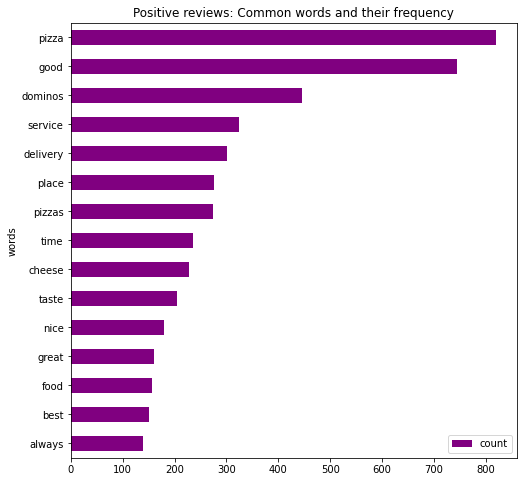

In [211]:
#cnt=Counter(df_review[df_review['Sentiment']==1].Review)
cnt=Counter(pos_reviews_list)
pos_common_words=pd.DataFrame(cnt.most_common(15), columns=['words','count'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color='purple')
ax.set_title("Positive reviews: Common words and their frequency")
plt.show()

In [212]:
#Creating bi-grams
bigram_measures=nltk.collocations.BigramAssocMeasures()

finder=nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df_review[df_review['Sentiment']==1].Review])

In [213]:
finder.apply_freq_filter(25)
bigram_scores=finder.score_ngrams(bigram_measures.pmi)
print(len(bigram_scores))

19


In [214]:
bigram_scores[0][0]
cnt_list=[]
for gram in bigram_scores:
  x = '_'.join(gram[0])
  cnt_list.append((x,gram[1]))
print(cnt_list[0:10])

[('choco_lava', 8.562206074681752), ('lava_cake', 8.27319260226712), ('peppy_paneer', 7.921508440232547), ('garlic_bread', 7.491191678019877), ('must_try', 7.406086872764467), ('cheese_burst', 6.276710389780735), ('delivery_boy', 5.8342452937767515), ('home_delivery', 5.245094996092162), ('nice_place', 3.362734034606678), ('dominos_outlet', 3.148299958103326)]


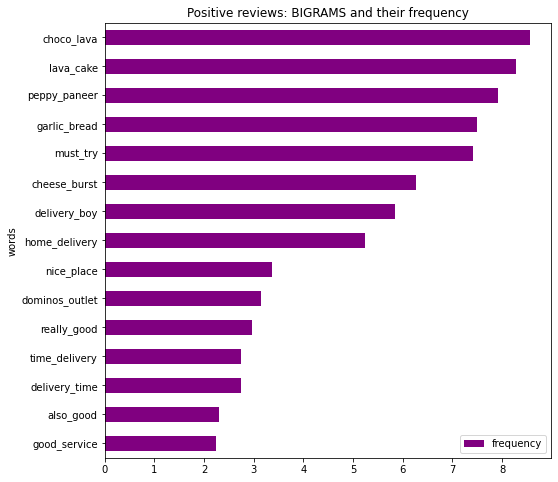

In [215]:
#cnt=Counter(df_review[df_review['Sentiment']==0].Review)
cnt=Counter(cnt_list)
pos_common_words=pd.DataFrame(cnt_list[0:15], columns=['words','frequency'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='frequency').plot.barh(x='words',y='frequency',ax=ax,color='purple')
ax.set_title("Positive reviews: BIGRAMS and their frequency")
plt.show()

For Negative Reviews

In [216]:
neg_reviews_list=[]
for rev in df_review[df_review['Sentiment']==0].Review:
  sent_list=rev.split()
  for w in sent_list:
    neg_reviews_list.append(w)


#Trial code for common words finder, again.
cnt=Counter(neg_reviews_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)

[('pizza', 668), ('not', 651), ('order', 475), ('dominos', 313), ('delivery', 286), ('cheese', 267), ('time', 212), ('ordered', 202), ('service', 193), ('no', 186), ('good', 183), ('late', 152), ('delivered', 150), ('bad', 146), ('worst', 133), ('food', 113), ('also', 112), ('experience', 112), ('even', 111), ('received', 101), ('one', 101), ('quality', 99), ('taste', 98), ('outlet', 98), ('got', 96), ('place', 96), ('pizzas', 94), ('burst', 92), ('dont', 91), ('didnt', 90), ('cold', 88), ('staff', 88), ('like', 86), ('get', 83), ('less', 78), ('zomato', 77), ('deliver', 75), ('never', 68), ('bread', 66), ('hour', 64), ('call', 62), ('mins', 62), ('disappointed', 60), ('pathetic', 58), ('veg', 57), ('ever', 55), ('customer', 53), ('garlic', 52), ('money', 51), ('chicken', 49), ('home', 49), ('really', 48), ('times', 48), ('much', 46), ('toppings', 45), ('refund', 45), ('poor', 44), ('properly', 44), ('please', 43), ('hot', 42), ('base', 41), ('minutes', 41), ('took', 40), ('online', 39

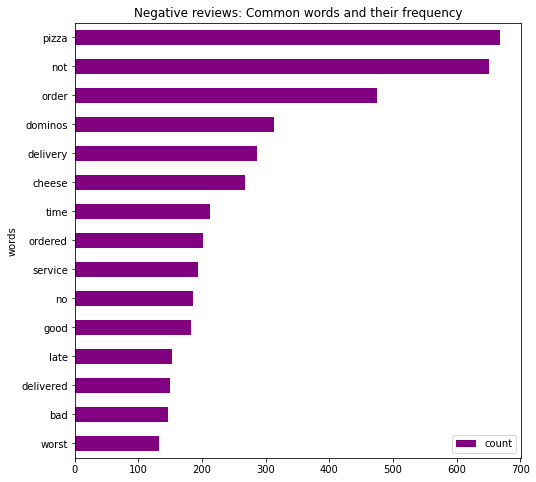

In [217]:
#cnt=Counter(df_review[df_review['Sentiment']==0].Review)
cnt=Counter(neg_reviews_list)
pos_common_words=pd.DataFrame(cnt.most_common(15), columns=['words','count'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color='purple')
ax.set_title("Negative reviews: Common words and their frequency")
plt.show()

In [218]:
#Creating bi-grams
bigram_measures=nltk.collocations.BigramAssocMeasures()

finder=nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df_review[df_review['Sentiment']==0].Review])

In [219]:
finder.apply_freq_filter(25)
bigram_scores=finder.score_ngrams(bigram_measures.pmi)
#print('_'.join(bigram_scores[0][0]))
print(len(bigram_scores))

16


In [220]:
bigram_scores[0][0]
cnt_list=[]
for gram in bigram_scores:
  x = '_'.join(gram[0])
  cnt_list.append((x,gram[1]))
print(cnt_list[0:10])

[('garlic_bread', 7.949224726928794), ('cheese_burst', 5.951102930664714), ('delivery_boy', 5.659718109733809), ('bad_experience', 5.359844096213143), ('home_delivery', 5.334514882813586), ('worst_experience', 5.0013462083118565), ('late_delivery', 4.127561968187305), ('worst_service', 4.1052127807126375), ('received_order', 3.603494997095531), ('not_good', 3.39662961176219)]


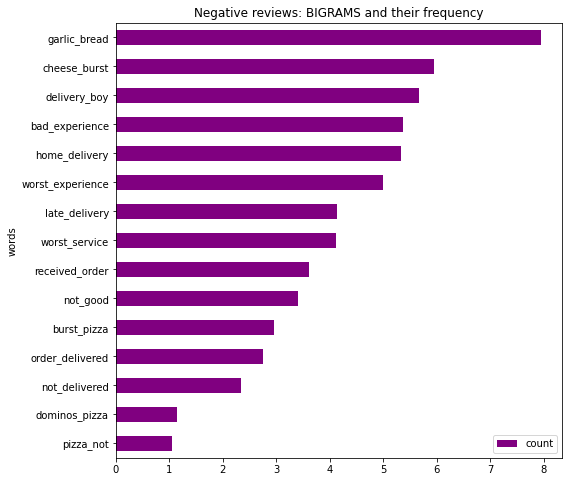

In [221]:
#cnt=Counter(df_review[df_review['Sentiment']==0].Review)
cnt=Counter(cnt_list)
pos_common_words=pd.DataFrame(cnt_list[0:15], columns=['words','count'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color='purple')
ax.set_title("Negative reviews: BIGRAMS and their frequency")
plt.show()

6. Tokenization

In [222]:
#Tokenization done to apply Lemmatization
w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
lemmatizer=nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
  return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]

df_review['Review']=df_review.Review.apply(lemmatize_text)
print(df_review.head())

                                                                                                                                                                                                          Review  \
0                                                                                                                                                                                                         [good]   
1                                                                                                                                                                                                 [waste, money]   
2                                                                                                                                                                                     [pizza, yum, little, late]   
3                                                                                                                                                       

From tokenized to normal

In [223]:
df_review['NewReview'] = df_review['Review'].apply(lambda s1: ' '.join(map(str,s1)) )

print(df_review['NewReview'].head())

0                                                                                                                                                                                  good
1                                                                                                                                                                           waste money
2                                                                                                                                                                 pizza yum little late
3                                                                                                                                                                 delivery person amaze
4    even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza
Name: NewReview, dtype: object


In [224]:
df_review['NewReview']=df_review['NewReview'].str.lower()
df_review.head()

,Review,Sentiment,NewReview
0,[good],1,good
1,"[waste, money]",0,waste money
2,"[pizza, yum, little, late]",1,pizza yum little late
3,"[delivery, person, amaze]",1,delivery person amaze
4,"[even, call, personally, even, give, special, instructions, receive, cold, pizza, base, hard, taste, stale, premade, think, chicken, parcel, really, hot, fresh, proper, quantity, really, disappoint, pizza]",0,even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza


# Sentiment Analysis

In [225]:
print("The number of samples in the dataset!")
pos_percent=(len(df_review[df_review['Sentiment']==1])/len(df_review)*100)
print("Positive reviews percentage: ",round(pos_percent,2),"%")
neg_percent=(len(df_review[df_review['Sentiment']==0])/len(df_review)*100)
print("Negative reviews percentage: ",round(neg_percent,2),"%")
print("Positive reviews: ",len(df_review[df_review['Sentiment']==1]))
print("Negative reviews: ",len(df_review[df_review['Sentiment']==0]))

The number of samples in the dataset!
Positive reviews percentage:  56.19 %
Negative reviews percentage:  43.81 %
Positive reviews:  1543
Negative reviews:  1203


Train-test split starts here!

In [226]:
from sklearn.model_selection import train_test_split

In [227]:
train_data,test_data=train_test_split(df_review,test_size=0.2,random_state=50)  #keep random_state=50 for higher precision and recall of 0 class when using SVM
#train_data,test_data=train_test_split(new_df_review,test_size=0.4,random_state=25)

In [228]:
print(df_review.shape)
print('test_data(Positive):',test_data[test_data['Sentiment']==1].count())
print('test_data(Negative):',test_data[test_data['Sentiment']==0].count())

print("train_data (Positive):",train_data[train_data['Sentiment']==1].count())
print('train_data (Negative):',train_data[train_data['Sentiment']==0].count())

(2746, 3)
test_data(Positive): Review       311
Sentiment    311
NewReview    311
dtype: int64
test_data(Negative): Review       239
Sentiment    239
NewReview    239
dtype: int64
train_data (Positive): Review       1232
Sentiment    1232
NewReview    1232
dtype: int64
train_data (Negative): Review       964
Sentiment    964
NewReview    964
dtype: int64


In [229]:
X_train=train_data['NewReview']
y_train=train_data['Sentiment']
X_test=test_data['NewReview']
y_test=test_data['Sentiment']

In [230]:
print(X_train.head())
print(X_test.head())

17                                                                                                                                                                                                                      delivery charge high even zomato pro members around rs dominos outlet literally next door house
1263                                                                                                                                          dominos dominos outlet locate thakur college thakur village dominos time favourite ambience outdoor indoor staff friendly pizza tasty yummy think one best outlet dominos
473     dominos best place crave pizza like domino pizza hut cheese burst die soo freak cheesy new addition menu burger pizza look like burger taste like pizza try burger pizza today superb soo cheesy hot soft lot veggies chicken piece new favourite guy wait goo hog youll definitely love cant miss piece heaven
2496                                                            

7. Vectorizer

In [231]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [232]:
train_vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii')
train_review_tfidf=train_vectorizer.fit_transform(X_train)

In [233]:
print(train_review_tfidf.shape)
type(train_review_tfidf)

(2196, 2786)


scipy.sparse.csr.csr_matrix

a. LOGISTIC REGRESSION

In [234]:
log_model=LogisticRegression().fit(train_review_tfidf, y_train)

In [235]:
#USE THIS WHEN TESTING ON SPLIT TEST DATA
nr=train_vectorizer.transform(X_test)
log_model.predict(nr)

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,

In [236]:
predicted=log_model.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

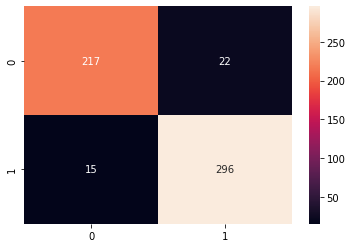

In [237]:
import seaborn as sns
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [238]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       239
           1       0.93      0.95      0.94       311

    accuracy                           0.93       550
   macro avg       0.93      0.93      0.93       550
weighted avg       0.93      0.93      0.93       550



b. SVM

In [239]:
from sklearn.svm import SVC
svclassifier=SVC(kernel='rbf',C=10,gamma=1)
svclassifier.fit(train_review_tfidf,y_train)

SVC(C=10, gamma=1)

In [240]:
nr=train_vectorizer.transform(X_test)
svclassifier.predict(nr)

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,

In [241]:
predicted=svclassifier.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

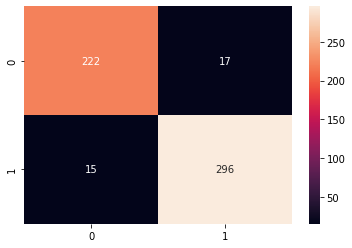

In [242]:
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [243]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       239
           1       0.95      0.95      0.95       311

    accuracy                           0.94       550
   macro avg       0.94      0.94      0.94       550
weighted avg       0.94      0.94      0.94       550



# Topic Modelling

In [244]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [245]:
corpus_bert=pd.DataFrame(df_review[df_review['Sentiment']==0].NewReview)
corpus_lda=pd.DataFrame(df_review[df_review['Sentiment']==0].NewReview)


In [246]:
corpus_bert=corpus_bert.reset_index()
corpus_lda=corpus_lda.reset_index()

In [247]:
print(corpus_bert.head())

   index  \
0      1   
1      4   
2      6   
3      9   
4     10   

                                                                                                                                                                            NewReview  
0                                                                                                                                                                         waste money  
1  even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza  
2                                                                                                extremely less toppings spend much dominos kind toppings provide really poor service  
3                                                                                                                                                               box not seal properly  
4      

In [248]:
!pip install pyLDAvis

In [249]:
train_vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii')
tfidf_=train_vectorizer.fit_transform(corpus_lda.NewReview)

num_components=10
lda=LatentDirichletAllocation(n_components=num_components,max_iter=100)
lda_tfidf=lda.fit(tfidf_)

In [250]:
#pyLDAvis for tfidf 
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tfidf,tfidf_,train_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.283858 -0.023168       1        1  48.593767
6      0.066753  0.130089       2        1  10.668122
3      0.008688 -0.133206       3        1   6.225094
0     -0.055479  0.022230       4        1   6.146060
2     -0.027488  0.012962       5        1   5.278310
5     -0.048558 -0.011939       6        1   5.078836
8     -0.044231  0.005946       7        1   4.854342
4     -0.082605 -0.001357       8        1   4.710803
1     -0.042092  0.007118       9        1   4.225012
9     -0.058848 -0.008674      10        1   4.219654, topic_info=          Term       Freq      Total Category  logprob  loglift
1026      late  37.000000  37.000000  Default  30.0000  30.0000
487   delivery  37.000000  37.000000  Default  29.0000  29.0000
791       good  26.000000  26.000000  Default  28.0000  28.0000
145        bad  24.000000  24.000000  Default  27.0000  27.0000
291     cheese  31.000000  31.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
723     forget   0.383348   1.360120  Topic10  -6.0035   1.8990
1154       min   0.588484   7.760130  Topic10  -5.5749   0.5862
1462   product   0.390754   1.703770  Topic10  -5.9843   1.6929
1243       non   0.429680   3.737911  Topic10  -5.8894   1.0022
209     bother   0.374839   1.465107  Topic10  -6.0259   1.8022

[523 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
7         1  0.573262              ac
7         9  0.286631              ac
46        9  0.472664           along
48        1  0.913948            also
52        1  0.698189          always
52        2  0.349094          always
72        4  0.696454        anything
84        9  0.742033           apply
101       2  0.736430    arrangements
102       1  0.744039          arrive
102       3  0.372020          arrive
105       7  0.814631            asap
107       1  0.955084             ask
119      10  0.877188       attentive
132       1  0.795158       available
132       6  0.198790       available
133       1  0.355582         average
133       4  0.355582         average
145       1  0.454714             bad
145       2  0.496051             bad
145       9  0.041338             bad
147      10  0.654463             bag
148       2  0.531506            bake
148       4  0.265753            bake
157       3  0.669384          barely
157       5  0.669384          barely
169       1  0.517507          become
180       1  0.720282            best
180       5  0.360141            best
181       1  0.974292          better
213       1  0.551725             box
213      10  0.275862             box
217       1  0.639203          branch
220       4  0.923386           bread
226       4  0.594566           bring
229       4  0.854356         brownie
231       3  0.678937              bt
232      10  0.897556          bubble
242       5  0.417526            burn
243       1  0.874078           burst
243       5  0.072840           burst
248       7  0.644551             buy
250       1  0.673375            cake
250       4  0.336687            cake
251       1  0.986696            call
253       1  0.843769          cancel
291       1  0.832806          cheese
291       2  0.032031          cheese
291       5  0.128124          cheese
294       2  0.599496           cheez
299       1  0.782172         chicken
299       3  0.130362         chicken
311       4  0.608733           choco
312       4  0.695243       chocolate
313       5  0.699968       chocolava
338       7  0.736333            coke
340       1  0.576856            cold
340       2  0.057686            cold
340       3  0.115371            cold
340       6  0.288428            cold
342       8  0.558500         collect
347       1  0.915977            come
354       2  0.810026   communication
360       2  0.856993    compensat

Using BERTopic

In [251]:
import warnings
warnings.filterwarnings("ignore")

In [252]:
!pip install bertopic[visualization] --quiet

In [253]:
from bertopic import BERTopic

In [254]:
corpus=list(corpus_bert.NewReview)
print(corpus[0:5])

['waste money', 'even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza', 'extremely less toppings spend much dominos kind toppings provide really poor service', 'box not seal properly', 'order deliver lately pizza cold garlic bread also cold didnt enjoy']


In [255]:
corpus=list(corpus_bert.NewReview)
print(corpus[0:5])

['waste money', 'even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza', 'extremely less toppings spend much dominos kind toppings provide really poor service', 'box not seal properly', 'order deliver lately pizza cold garlic bread also cold didnt enjoy']


In [265]:
bert_model=BERTopic(language="english", nr_topics=25)

In [266]:
topics,probs=bert_model.fit_transform(corpus)

In [267]:
#Getting most frequent topics
bert_model.get_topic_freq()

,Topic,Count
0,-1,405
1,0,131
2,1,56
3,2,53
4,3,53
5,4,42
6,5,35
7,6,35
8,7,31
9,8,30


In [268]:
bert_model.get_topics()

{-1: [('pizza', 0.03208710770350296),
  ('cheese', 0.02924134038338432),
  ('not', 0.023583148112588458),
  ('order', 0.022830182522908242),
  ('dominos', 0.01837081089357451),
  ('good', 0.017501374140746664),
  ('bread', 0.017001783193554193),
  ('time', 0.016809390916211447),
  ('get', 0.016245575797673707),
  ('burst', 0.01623981584105843)],
 0: [('order', 0.032954165664097826),
  ('call', 0.031154196958297197),
  ('dominos', 0.029750148704365025),
  ('service', 0.024919606339375445),
  ('delivery', 0.02455944333651778),
  ('deliver', 0.02288000396890132),
  ('get', 0.01965690955349471),
  ('not', 0.018425548752984525),
  ('time', 0.018315139489420273),
  ('say', 0.018247590287756514)],
 1: [('food', 0.16777213554143294),
  ('good', 0.06474231301607403),
  ('quality', 0.06459342059667264),
  ('not', 0.055960149791689055),
  ('taste', 0.054248127944603264),
  ('late', 0.04878914363995011),
  ('deliver', 0.04495563608496296),
  ('bad', 0.03617288281203853),
  ('come', 0.0352282082256

Visualization of BERTopic!

In [269]:
import warnings
warnings.filterwarnings("ignore")

In [270]:
topic_list=[i for i in range(len(bert_model.get_topics())-1)]
print(topic_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [271]:
bert_model.visualize_barchart(topic_list, n_words=10, height=300)

If you want to see the complaints (reviews) wrt to the topic

In [272]:
df_tpc = pd.DataFrame({'topic': topics, 'document': corpus})

In [274]:
df_tpc[df_tpc['topic']==15].document

29                                                                                                                                                                                                                                                                                                                                                                                                          guy no tissue no spoon chil flack
160                                                                                                                                                                                                                                                                                                                                                                                                     short staff cleanliness not well look
331                                                                                                                                         